# <font color='blue'>Segmentação de Clientes para uma Empresa de Varejo</font>

# 1 - Definindo o problema de negócio

### Uma empresa de varejo está interessada em segmentar seus clientes para melhor direcionar suas estratégias de marketing e atendimento ao cliente. Eles coletaram dados de transações passadas e informações demográficas dos clientes e desejam agrupar os clientes em segmentos distintos com base em seus padrões de compra e características demográficas.

# 2 - Decisões

### O problema é de clusterização. Portanto, faremos a abordagem de aprendizagem não supervisionada.

# 3 - Versão python e import dos pacotes utilizados

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
#pip install threadpoolctl==3.1.0

In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
#from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_score
from itertools import cycle
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# 4 - Dicionário de dados

In [4]:
# InvoiceNo: Número de identificação da fatura ou transação. Cada transação geralmente possui um número único.
# StockCode: Código de identificação do produto.
# Description: Descrição do produto.
# Quantity: A quantidade de itens vendidos em uma transação.
# InvoiceDate: Data e hora da transação.
# UnitPrice: Preço unitário do produto.
# CustomerID: Identificação do cliente.
# Country: País do cliente.

# 5 - Carregando o Conjunto de dados

In [5]:
# Carregando os dados
df = pd.read_excel('Online_Retail.xlsx')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 6 - Análise exploratória

### 6.1 Exclusão das colunas que não serão importantes 

In [7]:
df.shape

(541909, 8)

In [8]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [9]:
# vamos excluir as colunas que não serão necessárias para a clusterização  InvoiceNo  StockCode InvoiceDate CustomerID  

In [10]:
# Excluindo a coluna 'CustomerID'
df2 = df.drop(['InvoiceNo', 'StockCode', 'InvoiceDate', 'CustomerID' ], axis=1)

### 6.2 Tratando linhas duplicadas 

In [11]:
# Verifica registros duplicados (remove uma das duplicatas)
numero_duplicados = df2.duplicated().sum()
print('A quantidade de valores duplicados é: ', numero_duplicados)

A quantidade de valores duplicados é:  447743


In [12]:
# removendo as linhas duplicadas
df3 = df2.drop_duplicates()

In [13]:
numero_duplicados = df3.duplicated().sum()
print('A quantidade de valores duplicados é: ', numero_duplicados)

A quantidade de valores duplicados é:  0


### 6.3 Tratando valores ausentes

In [14]:
# Checando se há valores missing
df3.isnull().values.any()

True

In [15]:
# Verificando valores ausentes
numero_ausentes = df3.isnull().sum()
print('A quantidade de valores ausentes em cada coluna é:\n', numero_ausentes)

A quantidade de valores ausentes em cada coluna é:
 Description    266
Quantity         0
UnitPrice        0
Country          0
dtype: int64


In [16]:
df3.shape

(94166, 4)

In [17]:
# temos muitos registros. Portanto, podemos excluir os valores ausentes

In [18]:
df4 = df3.dropna()

In [19]:
numero_ausentes = df4.isnull().sum()
print('A quantidade de valores ausentes em cada coluna é:\n', numero_ausentes)

A quantidade de valores ausentes em cada coluna é:
 Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64


In [20]:
df4.shape

(93900, 4)

In [21]:
df4.head()

,Description,Quantity,UnitPrice,Country
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom
1,WHITE METAL LANTERN,6,3.39,United Kingdom
2,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom
4,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom


In [22]:
# Agregar os valores por produto, calculando a soma e a média
agregado1 = df4.groupby('Description').agg({'UnitPrice': ['sum','mean']})
# Ordenar o resultado em ordem decrescente da soma da 'UnitPrice'
agregado_sorted1 = agregado1.sort_values(by=('UnitPrice', 'sum'), ascending=False)
print(agregado_sorted1)

                                     UnitPrice             
                                           sum         mean
Description                                                
AMAZON FEE                           229558.78  7173.711875
DOTCOM POSTAGE                       203783.04   296.196279
Manual                               200191.51   453.949002
POSTAGE                               26390.36    95.964945
CRUK Commission                        7933.43   495.839375
...                                        ...          ...
Wrongly mrked had 85123a in box           0.00     0.000000
add stock to allocate online orders       0.00     0.000000
adjust                                    0.00     0.000000
adjustment                                0.00     0.000000
wrongly sold sets                         0.00     0.000000

[4223 rows x 2 columns]


In [23]:
# devemos também excluir os UnitPrice que são iguais a zero

In [24]:
# Deletar as linhas onde o valor da coluna 'UnitPrice' seja igual a zero
df5 = df4[df4['UnitPrice'] != 0]

In [25]:
df5.shape

(93083, 4)

In [26]:
# Agregar os valores por produto, calculando a soma e a média
agregado2 = df5.groupby('Description').agg({'UnitPrice': ['sum','mean']})
# Ordenar o resultado em ordem decrescente da soma da 'UnitPrice'
agregado_sorted2 = agregado2.sort_values(by=('UnitPrice', 'sum'), ascending=False)
print(agregado_sorted2.head(20))

                                   UnitPrice             
                                         sum         mean
Description                                              
AMAZON FEE                        229558.780  7173.711875
DOTCOM POSTAGE                    203783.040   296.627424
Manual                            200191.510   458.104142
POSTAGE                            26390.360    95.964945
CRUK Commission                     7933.430   495.839375
Bank Charges                        7305.991   280.999654
Discount                            5555.590    74.074533
REGENCY CAKESTAND 3 TIER            3190.320    13.692361
SAMPLES                             3139.760    52.329333
VINTAGE RED KITCHEN CABINET         1705.500   155.045455
SET/4 WHITE RETRO STORAGE CUBES     1320.290    41.259062
PICNIC BASKET WICKER 60 PIECES      1299.000   649.500000
LOVE SEAT ANTIQUE WHITE METAL       1287.500   107.291667
PARTY BUNTING                       1185.000     6.657303
RED RETROSPOT 

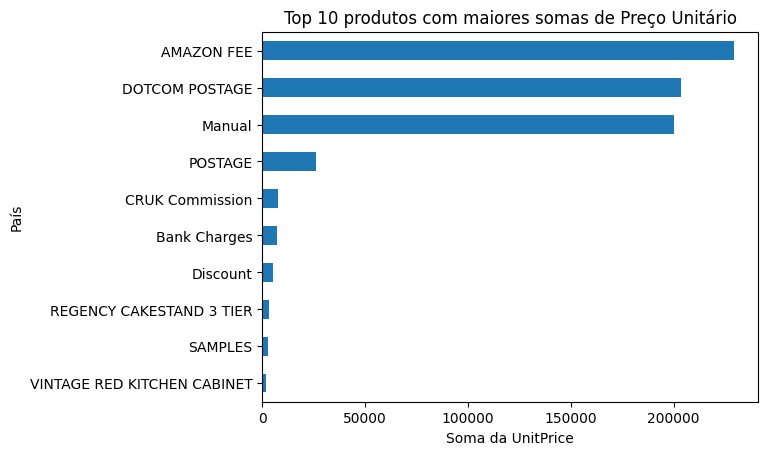

In [27]:
# Plotando um gráfico de barras horizontais
# Selecionar as top N linhas com maiores valores
N = 10  # Altere este valor conforme necessário
top_values = agregado_sorted2.head(N)
top_values.plot(kind='barh', y=('UnitPrice', 'sum'), legend=False)
plt.xlabel('Soma da UnitPrice')
plt.ylabel('País')
plt.title('Top {} produtos com maiores somas de Preço Unitário'.format(N))
plt.gca().invert_yaxis()  # Inverte a ordem dos países
plt.show()

In [28]:
# Agregar os valores por País, calculando a soma e a média
agregado3 = df5.groupby('Country').agg({'UnitPrice': ['sum','mean']})
# Ordenar o resultado em ordem decrescente da soma da 'UnitPrice'
agregado_sorted3 = agregado3.sort_values(by=('UnitPrice', 'sum'), ascending=False)
print(agregado_sorted3)

                       UnitPrice            
                             sum        mean
Country                                     
United Kingdom        819890.792   12.086011
EIRE                   25667.210    6.668540
Singapore              25076.630  116.095509
France                 20516.120    6.698048
Germany                16430.160    4.683626
Hong Kong              12131.230   46.838726
Spain                   8574.000    5.037603
Portugal                7857.860    7.235599
Norway                  5253.100    6.734744
Switzerland             4620.690    3.143327
Netherlands             4144.790    2.866383
Belgium                 3620.770    3.494952
Australia               3453.900    3.267644
Cyprus                  3318.050    5.851940
Channel Islands         2977.980    5.308342
Italy                   2965.500    4.790792
Finland                 2360.890    4.185975
Austria                 1231.850    3.655341
Sweden                  1090.830    2.956179
Unspecifie

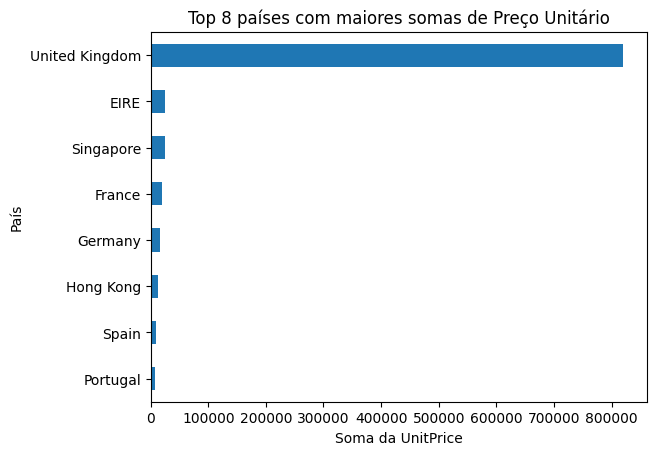

In [29]:
# Plotando um gráfico de barras horizontais
# Selecionar as top N linhas com maiores valores
N = 8  # Altere este valor conforme necessário
top_values = agregado_sorted3.head(N)
top_values.plot(kind='barh', y=('UnitPrice', 'sum'), legend=False)
plt.xlabel('Soma da UnitPrice')
plt.ylabel('País')
plt.title('Top {} países com maiores somas de Preço Unitário'.format(N))
plt.gca().invert_yaxis()  # Inverte a ordem dos países
plt.show()

In [30]:
# Agregar as quantidades por Produto, calculando a soma e a média
agregado4 = df5.groupby('Description').agg({'Quantity': ['sum','mean']})
# Ordenar o resultado em ordem decrescente da soma da 'Quantity'
agregado_sorted4 = agregado4.sort_values(by=('Quantity', 'sum'), ascending=False)
print(agregado_sorted4)

                                    Quantity            
                                         sum        mean
Description                                             
WORLD WAR 2 GLIDERS ASSTD DESIGNS      19220  270.704225
RABBIT NIGHT LIGHT                     17506  103.585799
POPCORN HOLDER                         16809  104.403727
PACK OF 12 LONDON TISSUES              12913  138.849462
PACK OF 72 RETROSPOT CAKE CASES        12333   81.138158
...                                      ...         ...
AMAZON FEE                               -28   -0.875000
SAMPLES                                  -56   -0.933333
TEA TIME PARTY BUNTING                  -778  -12.349206
Discount                               -1192  -15.893333
ROTATING SILVER ANGELS T-LIGHT HLDR    -5710  -62.065217

[4042 rows x 2 columns]


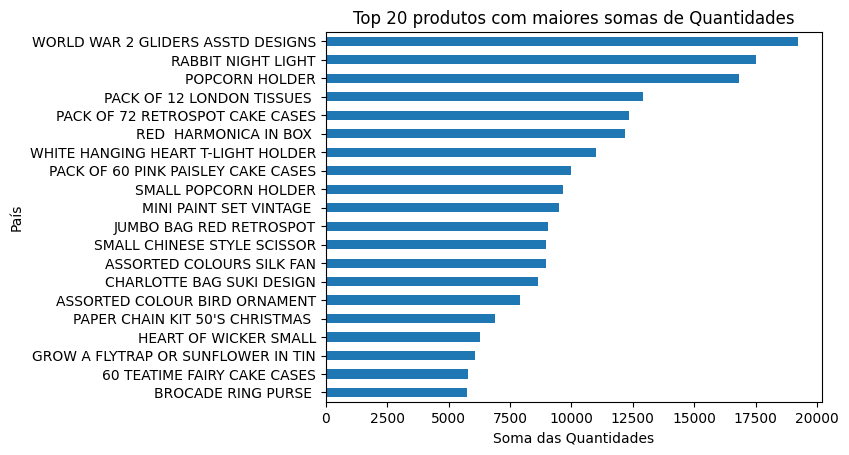

In [31]:
# Plotando um gráfico de barras horizontais
# Selecionar as top N linhas com maiores valores
N = 20  # Altere este valor conforme necessário
top_values = agregado_sorted4.head(N)
top_values.plot(kind='barh', y=('Quantity', 'sum'), legend=False)
plt.xlabel('Soma das Quantidades')
plt.ylabel('País')
plt.title('Top {} produtos com maiores somas de Quantidades'.format(N))
plt.gca().invert_yaxis()  # Inverte a ordem dos países
plt.show()

In [32]:
# Agregar as quantidades por País, calculando a soma e a média
agregado5 = df5.groupby('Country').agg({'Quantity': ['sum','mean']})
# Ordenar o resultado em ordem decrescente da soma da 'Quantity'
agregado_sorted5 = agregado5.sort_values(by=('Quantity', 'sum'), ascending=False)
print(agregado_sorted5)

                     Quantity           
                          sum       mean
Country                                 
United Kingdom        1231033  18.146658
Netherlands            115695  80.010373
EIRE                    83006  21.565601
Australia               71384  67.534532
Germany                 51182  14.590080
France                  46338  15.128306
Sweden                  26476  71.750678
Switzerland             23205  15.785714
Japan                   22874  72.615873
Spain                   18205  10.696240
Norway                  13620  17.461538
Belgium                 13253  12.792471
Portugal                11786  10.852670
Finland                  8898  15.776596
Channel Islands          7414  13.215686
Denmark                  7327  22.475460
Italy                    6602  10.665590
Cyprus                   5990  10.564374
Singapore                4816  22.296296
Hong Kong                4359  16.830116
Austria                  4272  12.676558
Israel          

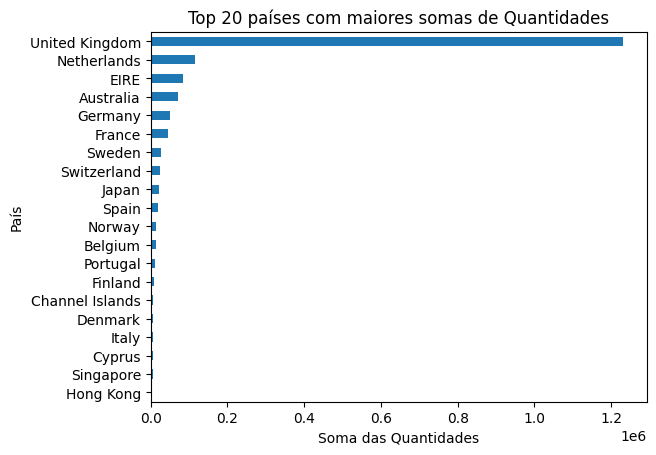

In [33]:
# Plotando um gráfico de barras horizontais
# Selecionar as top N linhas com maiores valores
N = 20  # Altere este valor conforme necessário
top_values = agregado_sorted5.head(N)
top_values.plot(kind='barh', y=('Quantity', 'sum'), legend=False)
plt.xlabel('Soma das Quantidades')
plt.ylabel('País')
plt.title('Top {} países com maiores somas de Quantidades'.format(N))
plt.gca().invert_yaxis()  # Inverte a ordem dos países
plt.show()

In [34]:
# Análises:

# 3 produtos que mais venderam em relação à soma total: AMAZON FEE, DOTCOM POSTAGE e Manual  
# 3 países que mais venderam em relação à soma total:United Kingdom,EIRE e France    
# 3 produtos que mais venderem em relação a número de unidades vendidas: WORLD WAR 2 GLIDERS ASSTD DESIGNS,
# RABBIT NIGHT LIGHT e POPCORN HOLDER     
# 3 países que mais venderem em relação a número de unidades vendidas:United Kingdom,Netherlands e EIRE  

In [35]:
df5.dtypes

Description     object
Quantity         int64
UnitPrice      float64
Country         object
dtype: object

In [36]:
df5['Description'].nunique()

4042

In [37]:
df5['Country'].nunique()

38

In [38]:
# manter somente compras com quantidades acima de zero
df6 = df5[df5['Quantity'] > 0]

In [39]:
#vamos copiar o df5 em df_final para utilizar no final, após a clusterização
df_final = df6.copy()

## 7 - Pré processamento dos dados

In [40]:
# Vamos transformar as variáveis categóricas em variáveis numéricas
# Como vários valores únicos nas colunas Description e Country, vamos utilizar o LabelEncoder

In [41]:
# Criar uma instância do LabelEncoder
label_encoder = LabelEncoder()

# Ajustar o encoder aos dados e transformar a variável categórica em numérica
df6['Description'] = label_encoder.fit_transform(df6['Description'])
df6['Country'] = label_encoder.fit_transform(df6['Country'])

In [42]:
df6.sample(10)

,Description,Quantity,UnitPrice,Country
226751,1010,1,5.79,36
519379,2681,48,2.46,36
230383,3451,8,1.25,36
303668,2857,6,4.96,36
318989,3373,3,0.42,36
37921,145,4,3.75,33
76451,2091,4,0.83,36
277159,3918,6,2.95,31
61017,1205,1,3.29,36
511848,1822,40,2.46,36


In [43]:
df6.dtypes

Description      int32
Quantity         int64
UnitPrice      float64
Country          int32
dtype: object

In [44]:
df6.sample(5)

,Description,Quantity,UnitPrice,Country
109069,894,24,2.55,36
65159,2179,1,2.46,36
21176,3428,1,1.66,36
493828,3590,7,0.65,36
42592,1838,2,0.65,36


In [45]:
df6.dtypes

Description      int32
Quantity         int64
UnitPrice      float64
Country          int32
dtype: object

In [46]:
df6.shape

(86867, 4)

In [47]:
# Vamos copiar o df6 em df7 - dataframe antes da aplicação de padronização
df7 = df6.copy()

In [48]:
# Normalizando e aplicando redução de dimensionalidade aos dados

In [49]:
# Criar uma instância do StandardScaler
scaler = StandardScaler()
# Normalizar as variáveis
df_normalized = scaler.fit_transform(df6)
# Aplica redução de dimensionalidade
pca = PCA(n_components=2).fit_transform(df_normalized)

## 8 - Machine Learning

In [50]:
# Imprimir os primeiros 5 pontos de pca
print("Primeiros 5 pontos de pca:", pca[:5])

Primeiros 5 pontos de pca: [[-0.74665695 -0.07592872]
 [-0.74611551 -0.07617029]
 [ 0.89176241  0.10079085]
 [ 0.35821309  0.03944881]
 [-0.19034954 -0.01798366]]


### 8.1 Algoritmo Kmeans

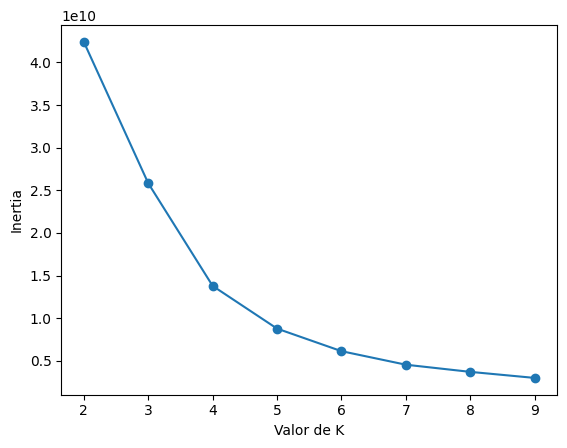

In [51]:
#vamos usar como ponto de partida a métrica Inertia
# Inertia = Soma das distâncias das amostras para o seu centro de agrupamento mais próximo.

# Lista de valores de K
Ks = range(2, 10)

# Lista para as métricas
valores_metrica = []

# Loop por diferentes modelos com diferentes valores de K
for K in Ks:
    modelo = KMeans(n_clusters = K, random_state = 101)
    modelo.fit(df6)
    valores_metrica.append(modelo.inertia_)

plt.plot(Ks, valores_metrica, 'o-')
plt.xlabel("Valor de K")
plt.ylabel("Inertia")
plt.show()

In [52]:
# pelo gráfico, vamos tentar com 4, 5 e 6 clusters

In [53]:
# Criando um modelo com K = 4
modelo_v1 = KMeans(n_clusters=4, random_state=42)
modelo_v1.fit(pca)
# Silhouette Score
labels = modelo_v1.labels_
silhouette_v1 = silhouette_score(pca, labels, metric = 'euclidean')
print(silhouette_v1)

0.5452008991106317


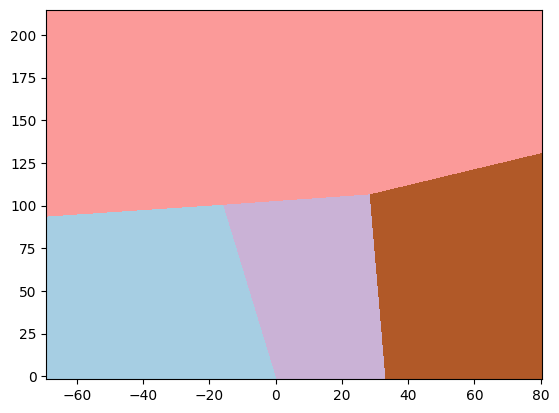

In [54]:
# Obtém os valores mínimos e máximos e organiza o shape
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() + 1, pca[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = modelo_v1.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
# Plot das áreas dos clusters
plt.figure(1)
plt.clf()
plt.imshow(Z, 
          interpolation = 'nearest',
          extent = (xx.min(), xx.max(), yy.min(), yy.max()),
          cmap = plt.cm.Paired,
          aspect = 'auto', 
          origin = 'lower')

In [55]:
# Criando um modelo com K = 5
modelo_v2 = KMeans(n_clusters = 5, random_state=42)
modelo_v2.fit(pca)
# Silhouette Score
labels = modelo_v2.labels_
silhouette_v2 = silhouette_score(pca, labels, metric = 'euclidean')
print(silhouette_v2)

0.537492463434444


In [56]:
# Criando um modelo com K = 6
modelo_v3 = KMeans(n_clusters = 6, random_state=42)
modelo_v3.fit(pca)
# Silhouette Score
labels = modelo_v3.labels_
silhouette_v3 = silhouette_score(pca, labels, metric = 'euclidean')
print(silhouette_v3)

0.5443746870045378


### 8.2 Algoritmo DBSCAN

In [58]:
# Construção do modelo
modelo_v4 = DBSCAN(eps = 0.5, min_samples = 5, metric = 'euclidean')
labels = modelo_v4.fit_predict(df6)

In [59]:
# Calcular métrica de classificação (silhouette score)
silhouette_v4  = silhouette_score(df6, labels)
print("Silhouette Score:", silhouette_v4)

Silhouette Score: -0.8761395289048297


### 8.3 Algoritmo MEAN SHIFT

In [60]:
# bandwidth = Comprimento da Interação entre os exemplos, também conhecido como a largura de banda do algoritmo.
bandwidth = estimate_bandwidth(df6, quantile = .3, n_samples = 500, random_state=42)

# Cria o modelo
modelo_v5 = MeanShift(bandwidth = bandwidth, bin_seeding = True)

# Treina o modelo
modelo_v5.fit(df6)

MeanShift(bandwidth=706.1404412424234, bin_seeding=True)

In [61]:
# Coleta os labels, centróides e número de clusters
labels = modelo_v5.labels_
cluster_centers = modelo_v5.cluster_centers_
n_clusters_ = labels.max()+1
print ("Número de clusters sugeridos: ", n_clusters_)

Número de clusters sugeridos:  17


In [62]:
# Calcular métrica de classificação (silhouette score)
silhouette_v5  = silhouette_score(df6, labels)
print("Silhouette Score:", silhouette_v5)

Silhouette Score: 0.5811730912035693


### 8.4 Avaliação dos modelos

In [63]:
# Defina os valores para cada modelo
modelos = ['KMEANS_4', 'KMEANS_5', 'KMEANS_6', 'DBSCAN', 'MEANSHIFT']
sil = [silhouette_v1, silhouette_v2, silhouette_v3, silhouette_v4, silhouette_v5]

In [64]:
# Crie um DataFrame usando Pandas
df_resumo_modelos = pd.DataFrame({
 'Modelo': modelos,
 'Silhouette': sil
})

In [65]:
# Melhores modelos considerando a métrica Silhouette mais importante
df_resumo_modelos_sil = df_resumo_modelos.sort_values(by='Silhouette', ascending=False)
# fazemos o índice começar em zero
df_resumo_modelos_sil =df_resumo_modelos_sil.reset_index(drop=True)
# para ordenar os modelos começando do 1, acrescentamos 1 ao indice
df_resumo_modelos_sil.index += 1
print(" Avaliação do modelos com base na Silhouette\n")
df_resumo_modelos_sil

 Avaliação do modelos com base na Silhouette



,Modelo,Silhouette
1,MEANSHIFT,0.581173
2,KMEANS_4,0.545201
3,KMEANS_6,0.544375
4,KMEANS_5,0.537492
5,DBSCAN,-0.876140


In [66]:
#Forma de avaliar a métrica silhouette

#Um valor próximo de 1 indica que os clusters estão bem separados uns dos outros e 
#que as amostras dentro de cada cluster estão muito próximas umas das outras, o que é considerado uma boa separação.

#Um valor próximo de 0 indica que há sobreposição entre os clusters ou que os clusters 
#estão muito próximos uns dos outros, o que pode indicar que os clusters não estão bem definidos.

#Um valor próximo de -1 indica que as amostras foram atribuídas ao cluster errado.

#Portanto, quanto mais próximo o valor do coeficiente silhouette estiver de 1, melhor é a qualidade dos clusters.

### O modelo_v1 apresentou os melhores resultados.

### Criando o Cluster Map com os clusters do modelo_v1 que apresentou melhor Silhouette Score.

In [67]:
# Cria o cluster map
df_final['cluster'] = modelo_v1.labels_

In [68]:
# Convertendo os valores da coluna 'cluster' para inteiros
df_final['cluster'] = df_final['cluster'].astype(int)

In [69]:
# obtendo os valores únicos de cluster
valores_unicos = np.unique(df_final['cluster'])
print("Os valores únicos de clusters são:", valores_unicos)

Os valores únicos de clusters são: [0 1 2 3]


In [70]:
# verificando se a quantidade de clusters está correta 
quantidade_valores_unicos = len(valores_unicos)
print("Quantidade de valores únicos:", quantidade_valores_unicos)

Quantidade de valores únicos: 4


In [71]:
df_final.dtypes

Description     object
Quantity         int64
UnitPrice      float64
Country         object
cluster          int32
dtype: object

In [72]:
# vendo a classificação de alguns clientes
df_final.sample(5)

,Description,Quantity,UnitPrice,Country,cluster
85532,HOT BATHS SOAP HOLDER,5,1.69,United Kingdom,2
383673,WOODLAND BUNNIES LOLLY MAKERS,30,2.08,Germany,0
133789,JUMBO BAG WOODLAND ANIMALS,100,1.65,Netherlands,0
163918,GOLD APERITIF GLASS,72,0.39,United Kingdom,2
46749,SKULLS STICKERS,18,0.85,United Kingdom,0


In [79]:
# Agrupando os 10 produtos mais vendidos para os clausters 0, 1, 2 e 3
# Filtrando o DataFrame para incluir apenas os clusters especificados (0, 1, 2 e 3)
df_clusters_especificos = df_final[df_final['cluster'].isin([0, 1, 2, 3])]

# Agrupando por 'cluster' e 'Description' e somar a quantidade vendida de cada produto em cada cluster
produtos_mais_vendidos_por_cluster = df_clusters_especificos.groupby(['cluster', 'Description'])['Quantity'].sum()

# Encontrando os 10 produtos mais vendidos para cada cluster
top_10_produtos_por_cluster = produtos_mais_vendidos_por_cluster.groupby('cluster').nlargest(10)

print(top_10_produtos_por_cluster)

cluster  cluster  Description                       
0        0        WORLD WAR 2 GLIDERS ASSTD DESIGNS     20324
                  RABBIT NIGHT LIGHT                    17593
                  WHITE HANGING HEART T-LIGHT HOLDER    13511
                  RED  HARMONICA IN BOX                 12189
                  POPCORN HOLDER                        11494
                  SMALL POPCORN HOLDER                   9689
                  SMALL CHINESE STYLE SCISSOR            8982
                  PACK OF 72 RETROSPOT CAKE CASES        6356
                  RED RETROSPOT CHARLOTTE BAG            5970
                  RAIN PONCHO RETROSPOT                  5711
1        1        PAPER CRAFT , LITTLE BIRDIE           80995
                  MEDIUM CERAMIC TOP STORAGE JAR        74215
2        2        PACK OF 12 LONDON TISSUES             12169
                  ASSORTED COLOURS SILK FAN              9056
                  CHARLOTTE BAG SUKI DESIGN              8348
                 

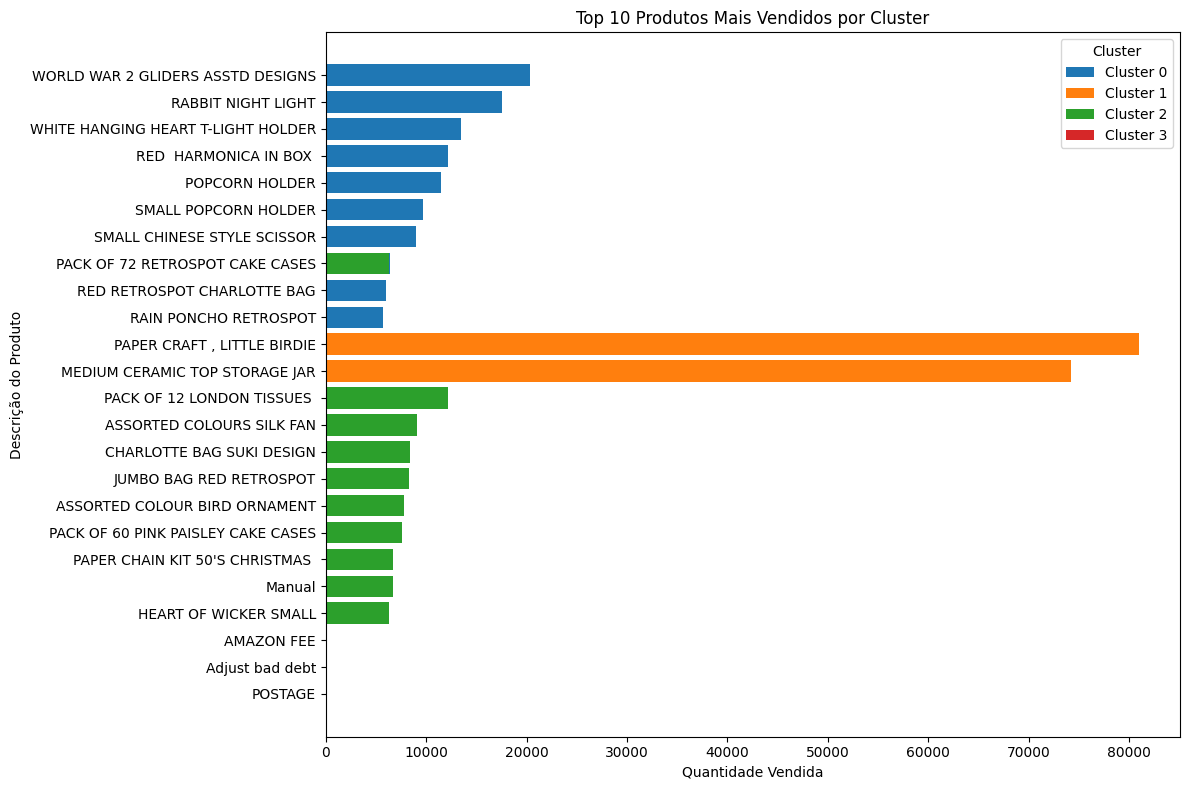

In [80]:
# Plotar o gráfico
plt.figure(figsize=(12, 8))

for cluster, data in top_10_produtos_por_cluster.groupby(level=0):
    plt.barh(data.index.get_level_values('Description'), data.values, label=f'Cluster {cluster}')

plt.xlabel('Quantidade Vendida')
plt.ylabel('Descrição do Produto')
plt.title('Top 10 Produtos Mais Vendidos por Cluster')
plt.legend(title='Cluster')
plt.gca().invert_yaxis()  # Inverter eixo y para que os produtos mais vendidos fiquem no topo
plt.tight_layout()
plt.show()

## Conclusão

## O modelo_v1 apresentou os melhores resultados. O df_final apresenta a coluna 'cluster' indicando cada cliente num dos 4 clusters obtidos.

### Fim